# A. Data Preprocessing and Cleaning

## Exchange Rate Processor

import pandas as pd
import numpy as np
from pathlib import Path

class ExchangeRateProcessor:
    """
    A class to handle pre-analysis and pre-processing of the food price dataset.
    """
    
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None
        self.df_processed = None
        
    def load_csv(self):
        self.df = pd.read_csv(self.filepath)
        self.nrows = self.df.shape[0]
        self.ncols = self.df.shape[1]
        
        print(f"✓ Dataset loaded: {self.nrows} rows, {self.ncols} columns")
        return self
    
    def explore(self):
        """
        Display basic information about the dataset:
        - Geographic coverage
        - Date range coverage
        - Missing value statistics
        """
        
        print("\n" + "="*60)
        print("DATASET OVERVIEW")
        print("="*60)
        
        # geographic coverage
        print(f"\nGeographic Coverage:")
        print(f"  - Countries: {self.df['country'].nunique()}")
        print(f"  - Regions: {self.df['adm1_name'].nunique()}")
        print(f"  - Provinces: {self.df['adm2_name'].nunique()}")
        print(f"  - Markets: {self.df['mkt_name'].nunique()}") # can be cities, barangays, muncipalities inside the province
        
        # date range
        print(f"\nTemporal Coverage:")
        print(f"  - Years: {sorted(self.df['year'].unique().tolist())}")
        
        # junk columns — food columns w/ a lot of missing values
        print(f"\nJunk Columns:")
        missing_entries = self.df.isnull() # returns dataframe of same shape where each cell is True if original cell is empty
        
        nmissing_entries = missing_entries.sum() / self.nrows * 100
        nmissing_entries = nmissing_entries.sort_values(ascending=False)
        
        print(f"  - Columns with >50% missing: {(nmissing_entries > 50).sum()}")
        print(f"  - Columns with >90% missing: {(nmissing_entries > 90).sum()}")
        
        return self
    
    def categorize_cols(self):
        """
        Categorize columns into groups for easier processing:
        - Geographic identifiers
        - Temporal identifiers
        - Metadata 
        - Price columns
        - Derived metrics
        """
        cols = self.df.columns.tolist()
        
        # geographic identifiers
        self.geo_cols = ['ISO3', 'country', 'adm1_name', 'adm2_name', 
                         'mkt_name', 'lat', 'lon', 'geo_id']
        
        # temporal identifiers
        self.time_cols = ['DATES', 'year', 'month']
        
        # metadata and quality indicators
        self.meta_cols = ['currency', 'components', 'start_dense_data', 
                          'last_survey_point', 'data_coverage', 
                          'data_coverage_recent', 'index_confidence_score', 
                          'spatially_interpolated']
        
        # base food item price columns (w/o prefixes)
        self.food_cols = [col for col in cols 
                          if not any(col.startswith(prefix) for prefix in 
                                   ['o_', 'h_', 'l_', 'c_', 'inflation_', 'trust_'])
                          and col not in self.geo_cols + self.time_cols + self.meta_cols]
        
        # derived metric columns (w/ prefixes)
        # o_ = opening price, h_ = high, l_ = low, c_ = closing
        self.derived_cols = {
            'open': [col for col in cols if col.startswith('o_') and not col.endswith('_index')],
            'high': [col for col in cols if col.startswith('h_') and not col.endswith('_index')],
            'low': [col for col in cols if col.startswith('l_') and not col.endswith('_index')],
            'close': [col for col in cols if col.startswith('c_') and not col.endswith('_index')],
            'inflation': [col for col in cols if col.startswith('inflation_') and not col.endswith('_index')],
            'trust': [col for col in cols if col.startswith('trust_') and not col.endswith('_index')]
        }
        
        # derived metric index columns 
        self.derived_index_cols = [col for col in cols 
                                   if any(col.startswith(prefix) for prefix in 
                                          ['o_', 'h_', 'l_', 'c_', 'inflation_', 'trust_']) 
                                   and col.endswith('_index')]
        
        print("\n" + "="*60)
        print("COLUMN GROUPS")
        print("="*60)
        print(f"Geographic: {len(self.geo_cols)} columns")
        print(f"Temporal: {len(self.time_cols)} columns")
        print(f"Metadata: {len(self.meta_cols)} columns")
        print(f"Base food items: {len(self.food_cols)} columns")
        print(f"Derived metric index: {len(self.derived_index_cols)} columns")
        print(f"Derived metrics:")
        for key, cols in self.derived_cols.items():
            print(f"  - {key}: {len(cols)} columns")
        
        return self
    
    def simplify(self):
        """
        Simplify dataset by keeping only the relevant columns:
        - year
        - region (adm2_name)
        - closing food prices
        Then remove columns with >50% missing entries
        """
        print("\n" + "="*60)
        print("SIMPLIFY DATASET")
        print("="*60)
        
        # keep relevant columns
        print("\nKeep relevant columns:")
        cols_to_keep = ['year', 'adm2_name'] + self.derived_cols['close']
        self.df_processed = self.df[cols_to_keep].copy()
        print(f"✓ Removed {self.ncols - len(cols_to_keep)} unnecessary columns")
        
        # remove junk columns
        print("\nRemove junk columns:")
        missing_entries = self.df_processed.isnull() # returns dataframe of same shape where each cell is True if original cell is empty
        nmissing_entries = missing_entries.sum() / self.df_processed.shape[0] * 100 # returns series (list) where index -> column, value -> percentage
    
        print(f"  - Columns with >50% missing: {(nmissing_entries > 50).sum()}")
        print(f"  - Columns with >90% missing: {(nmissing_entries > 90).sum()}")
        print(f"  - Columns with 100% missing: {(nmissing_entries == 100).sum()}")
        
        m = nmissing_entries.gt(90.0)
        cols_to_rmv = self.df_processed.loc[:,m].columns.tolist()   
        self.df_processed.drop(cols_to_rmv, axis=1, inplace=True)
        print(f"✓ Removed {len(cols_to_rmv)} junk columns")
        print(f"✓ Missing values: {self.df_processed.isnull().sum().sum()} cells")
        
        print("\nKeep columns:")
        for col in self.df_processed.columns:
            print(f"  - {col}")
        
        print("\nRemove rows outside of 2015-2025:")
        series_to_rmv =  ~(2015 <= self.df_processed['year']) & (self.df_processed['year'] <= 2025)
        self.df_processed.drop(self.df_processed[series_to_rmv].index, inplace = True)
        print(f"✓ Removed {len(series_to_rmv)}")
        
        return self

    def aggregate_prices(self):
        """
        Goup rows by region and year. Then, find mean price of each food item
        """

        print("\n" + "="*60)
        print("AGGREGATE DATASET")
        print("="*60)

        print("\nGroup rows by region and year:")
        self.df_processed = self.df_processed.groupby(['year', 'adm2_name']).mean()
        print(self.df_processed)
        self.df_processed.reset_index(inplace=True)
        
        return self

    def clean(self):
        pass
    
    def save_csv(self):
        input_path = Path(self.filepath)
        output_path = input_path.parent.parent / "data_set" / f"{input_path.stem}_processed{input_path.suffix}"
        
        self.df_processed.to_csv(output_path, index=False)
        print(f"\n✓ Data processed: {self.df_processed.shape[0]} rows, {self.df_processed.shape[1]} columns") 
        print(f"✓ Data saved to: {output_path}")
        
        return self

if __name__ == "__main__":
    preprocessor = ExchangeRateProcessor('data_set/exchange-rate.csv')
    
    # run preprocessing pipeline
    preprocessor.load_csv() \
                .explore() \
                .categorize_cols() \
                .simplify() \
                .aggregate_prices() \
                .save_csv()
    
    # processed dataframe
    df_processed = preprocessor.df_processed

# B. Exploratory Data Analysis

## Scatterplot for Research Question 1
**Food Price vs. Poverty Incidence**

In [1]:
#RESEARCH QUESTION 1
#
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd



#food prices dataset
df = pd.read_csv("data_set/consolidated_data_set.csv")
df["Year"] = df["Year"].astype("category")
df.describe()

,Beans,Cabbages,Carrots,Eggs,Beef Chops,Chicken Whole,Pork,Onions,Potatoes,Rice,Tomatoes,Annual Per Capita Poverty Threshold,Poverty Incidence Among Families (%),Magnitude of Poor Families (1000),Exchange Rate
count,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000
mean,91.580467,69.384762,85.009825,6.878702,265.329391,169.401741,255.585872,121.940752,87.859076,39.348248,59.007041,28527.551114,15.953669,36.368289,51.941636
std,14.435664,26.402486,32.704634,1.394994,65.691275,28.556074,62.495308,45.938078,27.458294,4.763140,22.230218,4060.665284,10.939558,33.382187,3.736004
min,58.592083,25.777500,33.724583,4.607083,157.838333,125.595000,162.279167,55.904722,38.688333,32.597500,24.171250,21264.000000,0.300000,0.140000,45.501667
25%,79.982500,47.004167,57.981667,5.760000,208.706667,146.021944,201.526667,84.279583,67.780000,36.083333,40.656667,25460.000000,7.400000,11.220000,49.253333
50%,89.789167,66.469667,79.114167,6.348333,255.907500,160.380833,226.136667,113.235000,79.875833,37.878333,54.348667,27828.000000,14.000000,27.700000,51.795000
75%,102.424000,86.315833,108.315000,8.086667,319.140833,194.127500,314.350000,149.402000,103.028000,41.124500,73.823333,30847.000000,22.000000,50.490000,55.630833
max,152.323333,152.705833,176.334000,11.948000,417.573000,244.968000,451.273000,303.979167,181.805000,56.346667,141.034167,41757.000000,75.300000,292.590000,57.289167


Year: 2015


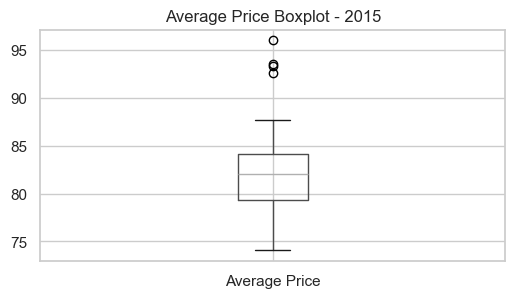

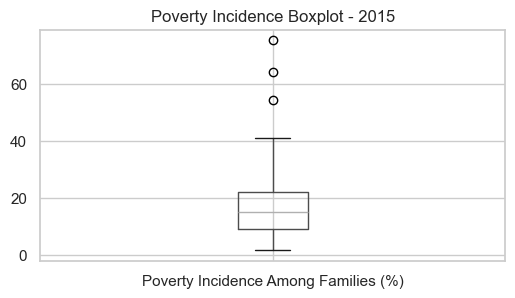

Correlation (Average Price vs Poverty Incidence) = -0.075

Year: 2016


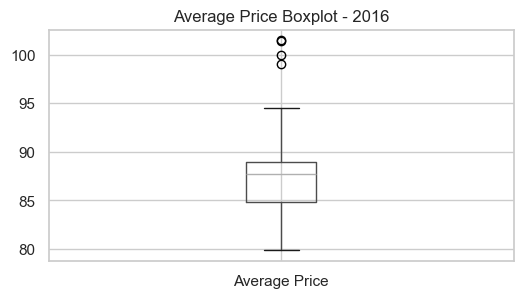

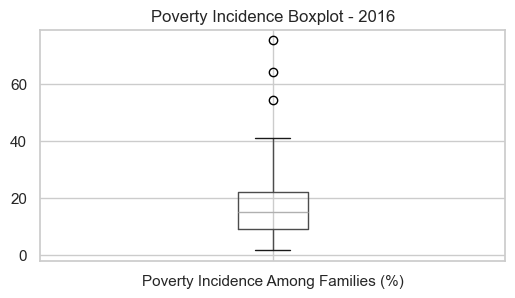

Correlation (Average Price vs Poverty Incidence) = -0.014

Year: 2017


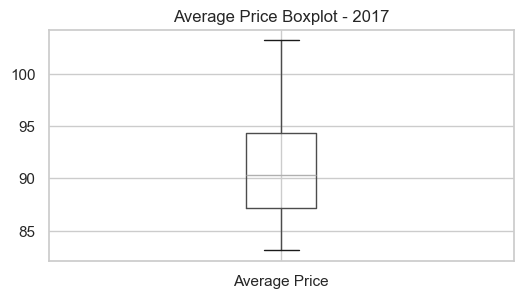

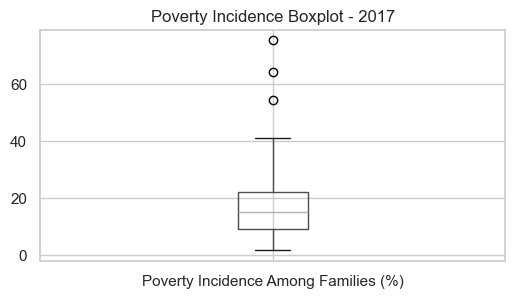

Correlation (Average Price vs Poverty Incidence) = -0.140

Year: 2018


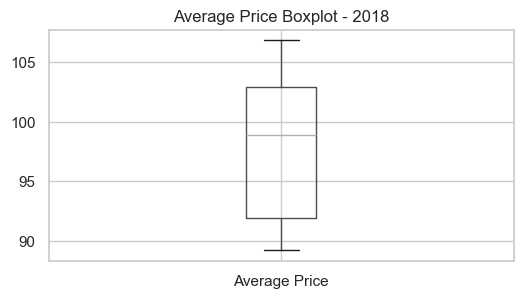

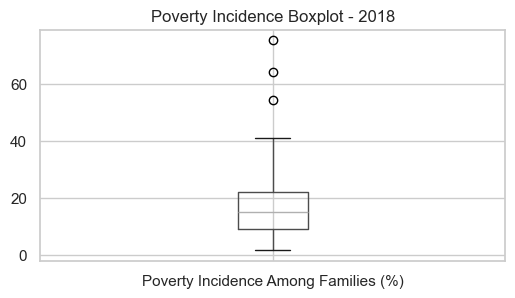

Correlation (Average Price vs Poverty Incidence) = -0.358

Year: 2019


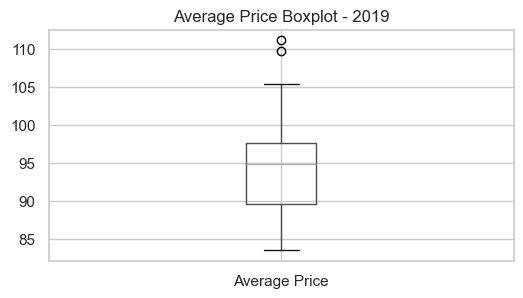

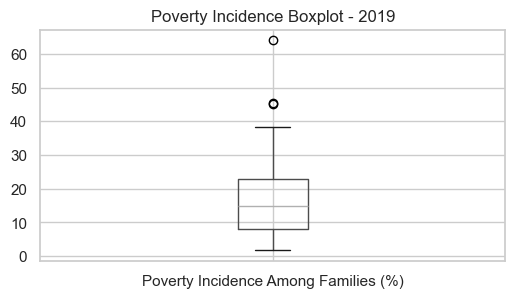

Correlation (Average Price vs Poverty Incidence) = -0.292

Year: 2020


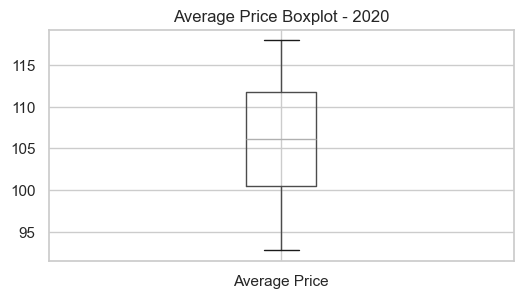

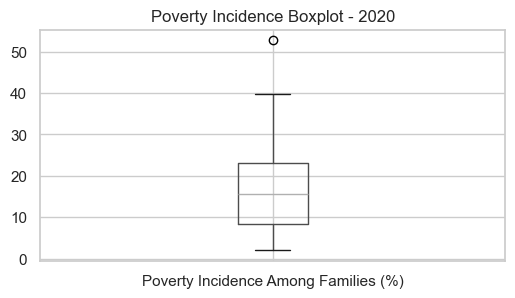

Correlation (Average Price vs Poverty Incidence) = -0.008

Year: 2021


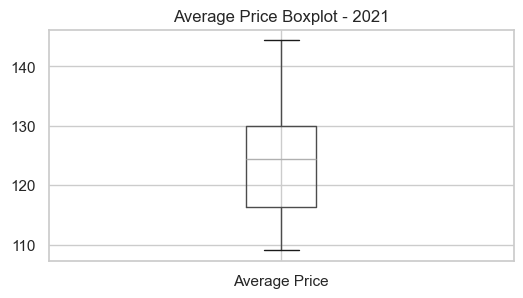

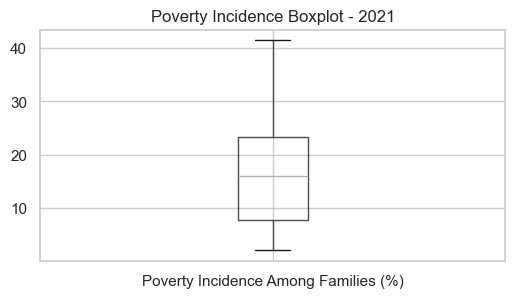

Correlation (Average Price vs Poverty Incidence) = -0.088

Year: 2022


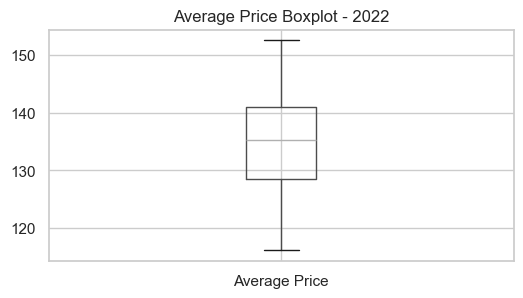

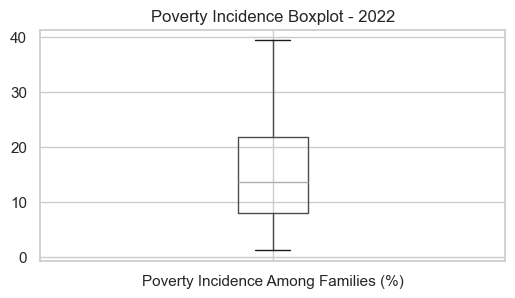

Correlation (Average Price vs Poverty Incidence) = 0.019

Year: 2023


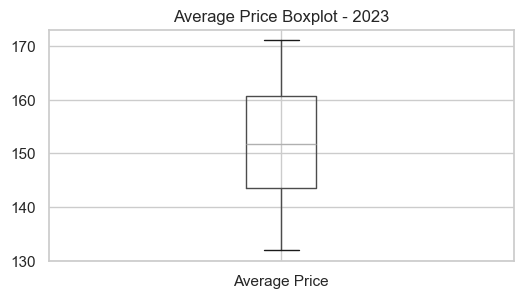

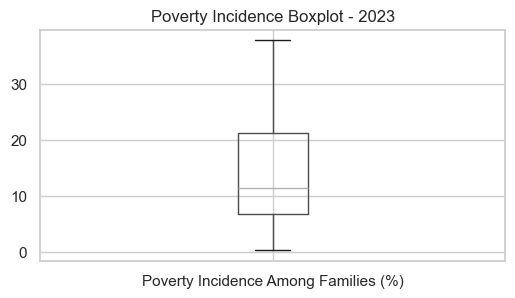

Correlation (Average Price vs Poverty Incidence) = 0.094

Year: 2024


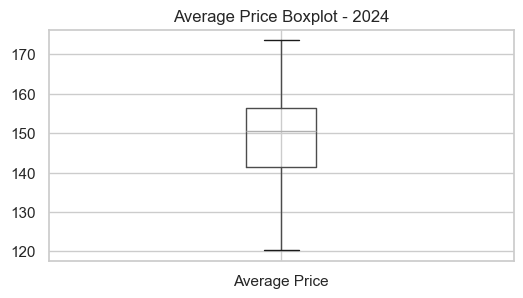

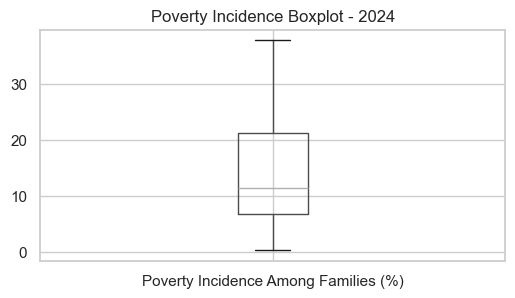

Correlation (Average Price vs Poverty Incidence) = 0.183

Year: 2025


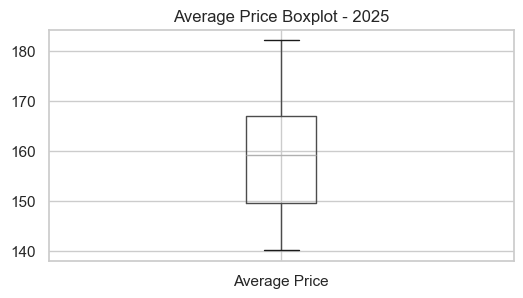

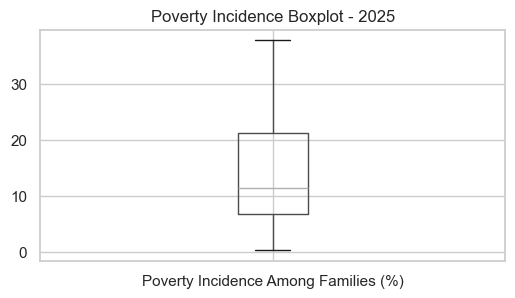

Correlation (Average Price vs Poverty Incidence) = 0.137



In [55]:
#get the average food price per province per year
df["Average Price"] = df.iloc[:, 3:13].mean(axis=1)

years = sorted(df['Year'].unique())

for year in years:
    df_year = df[df['Year'] == year]
    
    print(f"Year: {year}")
    
    # Boxplot for Average Price
    plt.figure(figsize=(6, 3))
    df_year.boxplot(column='Average Price')
    plt.title(f'Average Price Boxplot - {year}')
    plt.show()
    
    # Boxplot for Poverty Incidence
    plt.figure(figsize=(6, 3))
    df_year.boxplot(column='Poverty Incidence Among Families (%)')
    plt.title(f'Poverty Incidence Boxplot - {year}')
    plt.show()
    
    # Correlation coefficient
    corr = df_year['Average Price'].corr(df_year['Poverty Incidence Among Families (%)'])
    print(f"Correlation (Average Price vs Poverty Incidence) = {corr:.3f}\n")


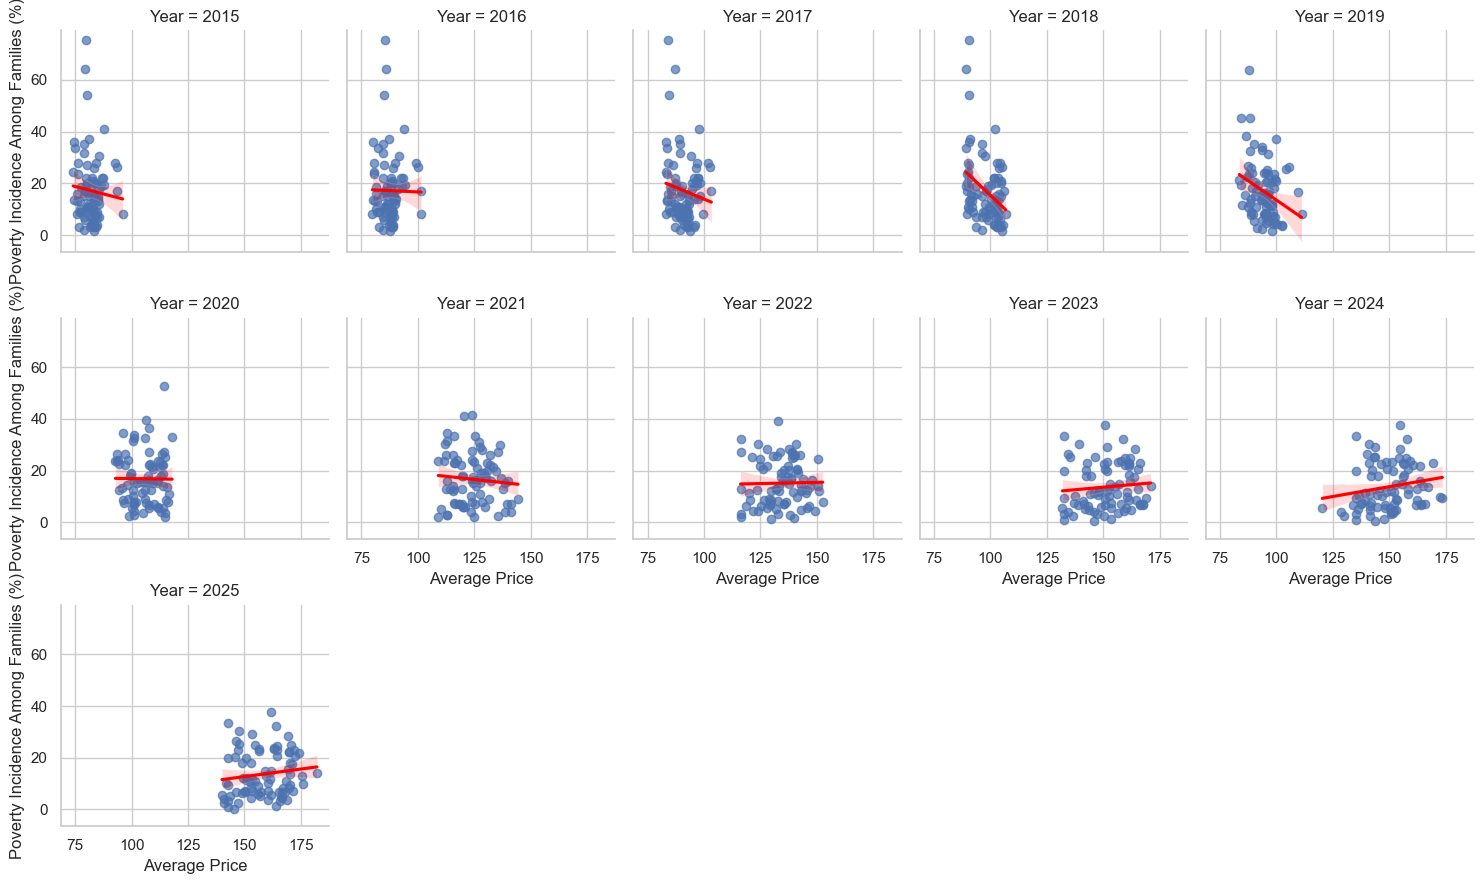

In [15]:
#Scatterplot (Food Price vs. Poverty Incidences)
import seaborn as sns
import matplotlib.pyplot as plt
rows = len(df)
x = "Average Price"
y = "Poverty Incidence Among Families (%)"

sns.lmplot(
    x="Average Price",
    y="Poverty Incidence Among Families (%)",
    col="Year",
    col_wrap=5,
    height=3,
    data=df,
    scatter_kws={"alpha":0.7},
    line_kws={"color":"red"}
)
plt.show()


<Figure size 1600x900 with 0 Axes>

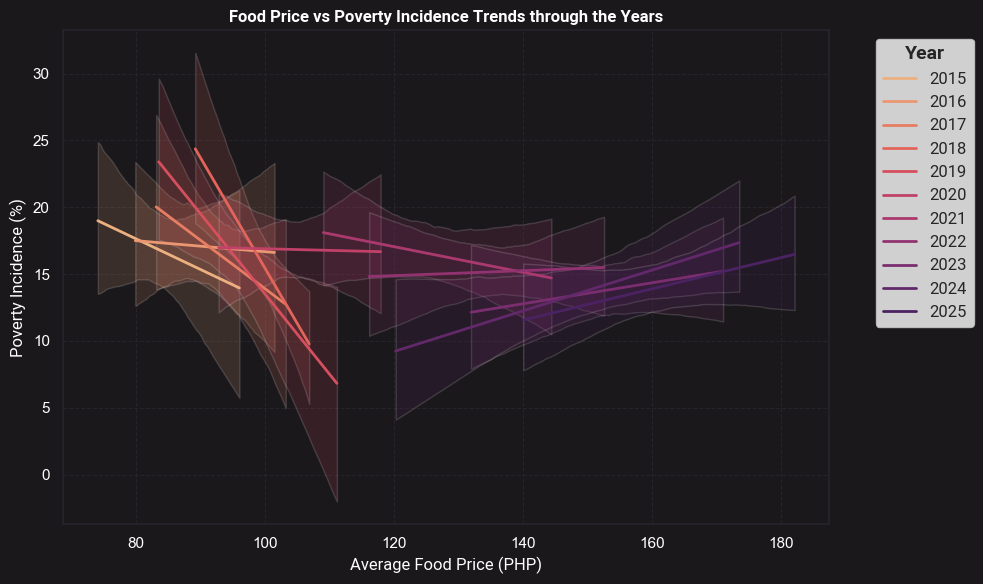

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
dpi = 100  # dots per inch
height_px = 900
width_px = 1600  # example width in pixels

plt.figure(figsize=(width_px/dpi, height_px/dpi), dpi=dpi)
fig, ax = plt.subplots(figsize=(10, 6), facecolor="#1B181C")  # figure background
ax.set_facecolor("#1B181C")  # plot/axes background
ax = plt.gca() 
ax.grid(True, color="#27232a", linestyle="--", linewidth=0.8)
ax.tick_params(axis="x", colors="white")
ax.tick_params(axis="y", colors="white")
for spine in ax.spines.values():
    spine.set_color("#27232a")

years = sorted(df['Year'].unique())
cmap = plt.colormaps["flare"]  # use new API

colors = [cmap(i / (len(years)-1)) for i in range(len(years))]

for i, year in enumerate(years):
    df_year = df[df['Year'] == year]
    sns.regplot(
        x="Average Price",
        y="Poverty Incidence Among Families (%)",
        data=df_year,
        scatter=False,
        color=colors[i],
        label=str(year),
        line_kws={"linewidth": 2}
    )
roboto = fm.FontProperties(family="Roboto", weight="regular", size=12)
roboto_bold = fm.FontProperties(family="Roboto", weight="bold", size=14)

plt.xlabel("Average Food Price (PHP)", color = "white", fontname="Roboto" )
plt.ylabel("Poverty Incidence (%)", color = "white", fontname="Roboto")
plt.title("Food Price vs Poverty Incidence Trends through the Years", color = "white", fontname="Roboto", fontweight="bold")
legend = plt.legend(title="Year",bbox_to_anchor=(1.05, 1), loc='upper left', prop=roboto)          # legend text
legend.get_title().set_fontproperties(roboto_bold)
plt.tight_layout()
#save the plot as png
plt.savefig(r"sustainabytes_portfolio\public\nutshellv1.png", dpi=300, bbox_inches="tight")
plt.show()





## Scatterplots for Research Question #2
Exchange Rate vs. Food Price per Food Type